# Starter code

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# In case of OSError: [Errno 107] Transport endpoint is not connected, restart Kernel

FOLDERNAME = 'Depth_Estimation'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))


# this changes the working directory to the folder, and allows us to perform version control operations
%cd drive/My\ Drive/$FOLDERNAME
!git config --global user.email "arjun2000ashok@gmail.com"
!git config --global user.name "Arjun Ashok"



import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)

import numpy as np
np.random.seed(0)

from PIL import Image
from io import BytesIO
%matplotlib inline

%load_ext autoreload
%autoreload 2
!pip install wandb -qq
import wandb
!wandb login

# Git commit and push

In [ ]:
# !git reset --soft HEAD~1 # UNDO PREVIOUS COMMIT AND PUT THOSE FILES IN STAGING AREA
# !git status # - VIEW STAGED, UNTRACKED FILES
# !git reset HEAD -- . # - TO UNSTAGE FILES
# !git log # LOG

In [ ]:
!git add .
!git commit -m 'Added lines for model 2, tested on model 2'
!git push -u origin master

[master fa30e50] New model at stake
 2 files changed, 6 insertions(+), 13 deletions(-)
 rewrite Depth Estimation.ipynb (91%)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 2.38 KiB | 162.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/aiarjun/Monocular-Depth-Estimation.git
   7111de6..fa30e50  master -> master
Branch 'master' set up to track remote branch 'master' from 'origin'.


In [ ]:
# !git pull

Already up to date.


# Dataset exploration

In [ ]:
# do not click this cell again

from model.net import DenseDepth, DenseDepthWithUpconvolution
from model.dataloader import DataLoaders
from utils import *
from evaluate import *

dataloaders = DataLoaders('nyu_data.zip', resized = False)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model = DenseDepth()
model = DenseDepthWithUpconvolution(model)
model = model.to(device)
train_dl = dataloaders.get_train_dataloader(batch_size = 8)
batch = next(iter(train_dl))
img, depth = batch['img'][0], batch['depth'][0]

In [ ]:
import torch.nn as nn
input = torch.randn(1, 1, 240, 320)
upsample = nn.ConvTranspose2d(1, 1, 5, stride=2, padding=2, output_padding = 1)
output = upsample(input)
output.size()

torch.Size([1, 1, 480, 640])

In [ ]:
print([param for param in upsample.parameters()])

[Parameter containing:
tensor([[[[-0.0981, -0.0951,  0.1312, -0.0914, -0.1234],
          [ 0.1078,  0.0170, -0.1381, -0.0049,  0.1087],
          [-0.1871,  0.1625, -0.0319,  0.0698,  0.1469],
          [ 0.1589, -0.1575, -0.0875,  0.1638, -0.0412],
          [ 0.0028,  0.1253,  0.0357, -0.1683,  0.1957]]]], requires_grad=True), Parameter containing:
tensor([0.0642], requires_grad=True)]


# Evaluate on complete validation set

In [7]:
# do not click this cell again

from model.net import DenseDepth, DenseDepthWithUpconvolution
from model.dataloader import DataLoaders
from utils import *
from evaluate import *

dataloaders = DataLoaders('nyu_data.zip', resized = False)

In [9]:
checkpoint_file = 'epoch_13.pth.tar'

wandb.init(id="kaggle_script_mod_5", project="depth_estimation", resume='allow') # we will not watching the model for now
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = DenseDepth(); model = model.to(device) # Model 1
model = DenseDepthWithUpconvolution(model); model = model.to(device) # Model 2, comment if using model 1
print('Loading checkpoint from cloud storage:',checkpoint_file)
load_checkpoint(wandb.restore(checkpoint_file).name, model)
print('Loaded checkpoint from cloud storage:',checkpoint_file) 
test_metrics_collection = []

Streaming file created twice in same run: /content/drive/My Drive/Depth_Estimation/wandb/run-20200719_155521-kaggle_script_mod_5/wandb-history.jsonl
Streaming file created twice in same run: /content/drive/My Drive/Depth_Estimation/wandb/run-20200719_155521-kaggle_script_mod_5/wandb-events.jsonl


Loading checkpoint from cloud storage: epoch_13.pth.tar
Loaded checkpoint from cloud storage: epoch_13.pth.tar


In [11]:
config = {'test_batch_size': 1, 'test_metrics_log_interval': 50}
loss, metrics = evaluate_full(model, dataloaders.get_val_dataloader, config)
test_metrics_collection.append({'config': config, 'loss': loss, 'metrics': metrics})

Batch size: 1, Number of batches: 5069
Iteration [0/5069], Average loss: 5.363708 
 Average metrics {'d1_accuracy': tensor(0.9724, device='cuda:0'), 'd2_accuracy': tensor(0.9922, device='cuda:0'), 'd3_accuracy': tensor(0.9975, device='cuda:0'), 'relative_err': tensor(0.0438, device='cuda:0'), 'rmse': tensor(0.2363, device='cuda:0'), 'log10_error': tensor(0.0190, device='cuda:0')}
Iteration [50/5069], Average loss: 4.742198 
 Average metrics {'d1_accuracy': tensor(0.9668, device='cuda:0'), 'd2_accuracy': tensor(0.9908, device='cuda:0'), 'd3_accuracy': tensor(0.9976, device='cuda:0'), 'relative_err': tensor(0.0494, device='cuda:0'), 'rmse': tensor(0.2414, device='cuda:0'), 'log10_error': tensor(0.0219, device='cuda:0')}
Iteration [100/5069], Average loss: 4.984882 
 Average metrics {'d1_accuracy': tensor(0.9679, device='cuda:0'), 'd2_accuracy': tensor(0.9909, device='cuda:0'), 'd3_accuracy': tensor(0.9977, device='cuda:0'), 'relative_err': tensor(0.0487, device='cuda:0'), 'rmse': tensor(

NameError: ignored

# Single image evaluate code

In [12]:
# run the previous cells before running this cell (model loading, dataloader, config)
batch_size = 2
test_images, test_depths, test_preds, test_loss, test_metrics = evaluate(model, dataloaders.get_val_dataloader, batch_size)

In [13]:
plot_sample_tensor(test_images[1], test_depths[1])

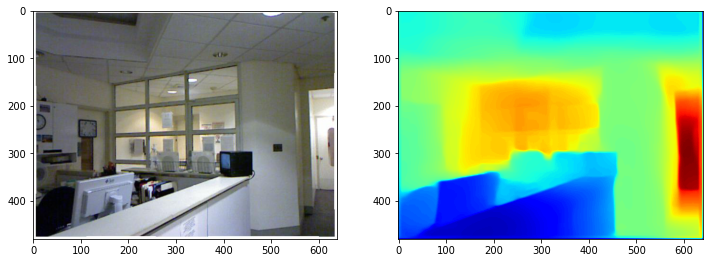

In [14]:
plot_sample_tensor(test_images[1], test_preds[1])

# Exploring the test.zip

In [4]:
from model.dataloader import get_test_data
samples, crop = get_test_data('nyu_test.zip') # gets img and depth data of same size(480 x 640)

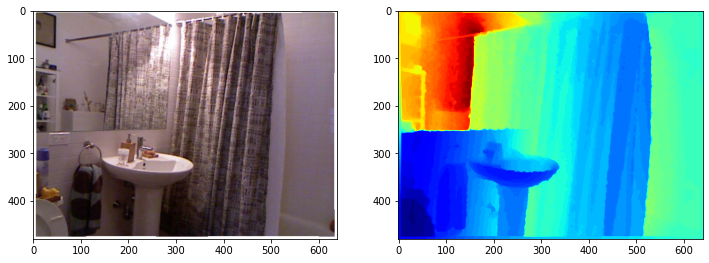

In [27]:
#without the eigen crop

from utils import *
import random

idx = random.randint(0, len(samples))
sample = samples[idx]

img = sample['img']
depth = sample['depth']


# flipped_image = sample['img'].numpy()[:,:,::-1].copy()
# img = torch.from_numpy(sample['img'].numpy()[:,:,::-1].copy())
# flipped_depth = sample['depth'].numpy()[:,:,::-1].copy()
# depth = torch.from_numpy(flipped_depth)

plot_sample_tensor(img, depth)

In [30]:
# our model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.eval()
predicted_depths = model(sample['img'].unsqueeze(0).to(device))
# plot_sample_tensor(img, predicted_depths[0])

In [ ]:
predicted_depths.shape

# Evaluate on test set

In [ ]:
from model.net import DenseDepth, DenseDepthWithUpconvolution
from utils import *

checkpoint_file = 'epoch_13.pth.tar'

wandb.init(id="kaggle_script_mod_5", project="depth_estimation", resume='allow') # we will not watching the model for now
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = DenseDepth(); model = model.to(device) # Model 1 DO NOT COMMENT
model = DenseDepthWithUpconvolution(model); model = model.to(device) # Model 2
print('Loading checkpoint from cloud storage:',checkpoint_file)
load_checkpoint(wandb.restore(checkpoint_file).name, model)
print('Loaded checkpoint from cloud storage:',checkpoint_file) 

In [8]:
# run only once
from model.dataloader import get_test_data
samples, crop = get_test_data('nyu_test.zip') # gets img and depth data of same size(480 x 640)
print('Number of samples: ', len(samples))

Number of samples:  654


In [15]:
from evaluate import evaluate_list

test_batch_size = 6

test_metrics = evaluate_list(model, samples, crop, test_batch_size)

In [16]:
display(test_metrics)

{'d1_accuracy': tensor(0.8380, device='cuda:0'),
 'd2_accuracy': tensor(0.9709, device='cuda:0'),
 'd3_accuracy': tensor(0.9937, device='cuda:0'),
 'log10_error': tensor(0.0550, device='cuda:0'),
 'relative_err': tensor(0.1284, device='cuda:0'),
 'rmse': tensor(0.5573, device='cuda:0')}

# Results
No mirroring at inference:

```
{'d1_accuracy': tensor(0.8366, device='cuda:0'),
 'd2_accuracy': tensor(0.9705, device='cuda:0'),
 'd3_accuracy': tensor(0.9935, device='cuda:0'),
 'log10_error': tensor(0.0552, device='cuda:0'),
 'relative_err': tensor(0.1305, device='cuda:0'),
 'rmse': tensor(0.552833, device='cuda:0')}
```

Mirroring after upsampling, and averaging w 0.5
```
{'d1_accuracy': tensor(0.8369, device='cuda:0'),
 'd2_accuracy': tensor(0.9706, device='cuda:0'),
 'd3_accuracy': tensor(0.9936, device='cuda:0'),
 'log10_error': tensor(0.0550, device='cuda:0'),
 'relative_err': tensor(0.1303, device='cuda:0'),
 'rmse': tensor(0.5529, device='cuda:0')}
```

Using a pretrained model, and tuning just an upconvolution layer on top:



```
{'d1_accuracy': tensor(0.8380, device='cuda:0'),
 'd2_accuracy': tensor(0.9709, device='cuda:0'),
 'd3_accuracy': tensor(0.9937, device='cuda:0'),
 'log10_error': tensor(0.0550, device='cuda:0'),
 'relative_err': tensor(0.1284, device='cuda:0'),
 'rmse': tensor(0.5573, device='cuda:0')}
 ```

